### Image Classification: MNIST Handwritten Digit

In [1]:
# Import all relevant modules
import os
import time
from IPython import display

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as T

# other modules
import res.viz_utils as vu
from res.plot_lib import plot_data, plot_model, plot_results, set_default

/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: /Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
set_default()

In [3]:
# Constants
DATA_DIR = "data"
MODEL_DIR = "models"

EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
LAMBDA_L2 = 1e-5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Load MNIST dataset

In [4]:
# Load training and test data
training_data = datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=T.ToTensor(), # convert to Tensor and normalize to (0, 1)
)

test_data = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=T.ToTensor(), # convert to Tensor and normalize to (0,1)
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

img_np : 0.0 1.0


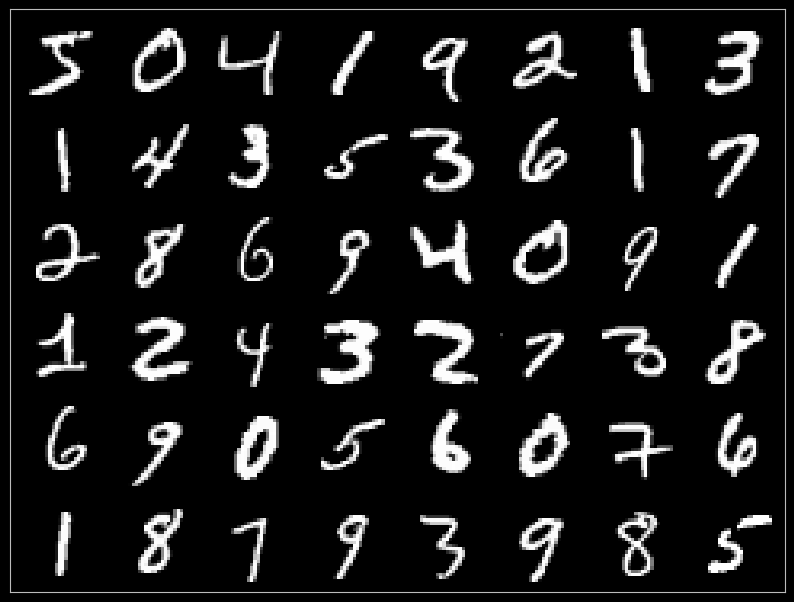

In [6]:
# Show training samples
grid = vu.set_grid(train_dataloader.dataset.data, num_cells=48)
vu.show(grid)

img_np : 0.0 1.0


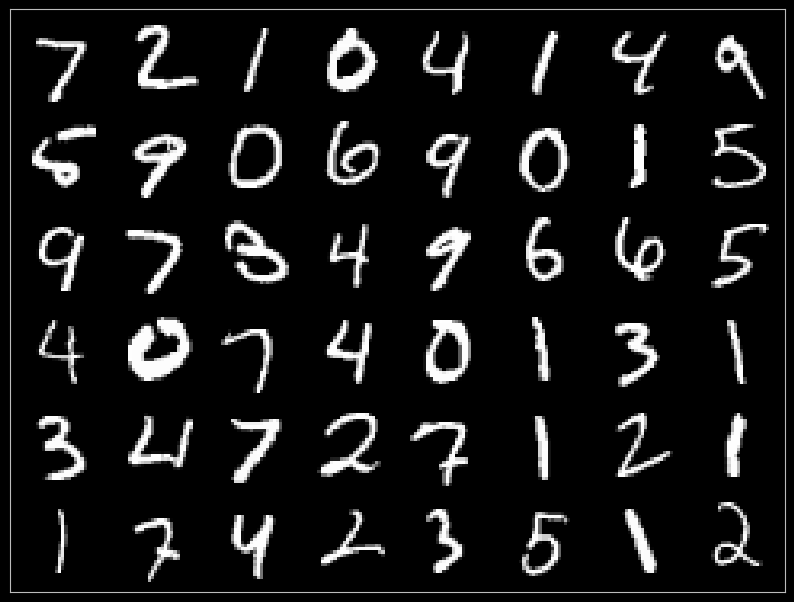

In [7]:
# Show test samples
grid = vu.set_grid(test_dataloader.dataset.data, num_cells=48)
vu.show(grid)

In [8]:
X = train_dataloader.dataset.data
y = train_dataloader.dataset.targets

In [9]:
print(X.size())
print(y.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


### Create NN model

In [10]:
# Define model: MLP
print(f"Using {DEVICE} device")

model = nn.Sequential(
    nn.Linear(784, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 10)
)

print(model)

model.to(DEVICE)

model_path = os.path.join(MODEL_DIR, "mlp_mnist.pth")

Using cpu device
Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): Tanh()
  (4): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
opt = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=LAMBDA_L2
)

### Model Training and Inference

In [12]:
def train(dataloader, model, loss_fn, opt):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        # print(batch, X.size(), y.size(), sep=' || ')

        # Flatten the input dimentionality
        X = torch.flatten(X, start_dim=1)

        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backprop
        opt.zero_grad()

        loss.backward()
        opt.step()

        if batch % 100 == 0:
            loss_val = loss.item()
            current = batch * len(X)
            print(f"### [Batch-{batch}]-Loss : {loss:>7f} [{current:>5d}]/{size:>5d}")


In [13]:
def infer(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    loss, correct = 0, 0
    num_batches = len(dataloader)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            X = torch.flatten(X, start_dim=1)
            y_pred = model(X)
            loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    return loss, correct

In [14]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Mini-batch gradient descent training
for t in range(EPOCHS):
    # Measure loss and accuracy
    train_loss, train_acc = infer(train_dataloader, model, loss_fn)
    test_loss, test_acc = infer(test_dataloader, model, loss_fn)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    
    display.clear_output(wait=True)
    print(f"Epoch {t}/{EPOCHS} -- train loss: {train_loss:>.4f}, train acc: {train_acc:>.2f}, test loss: {test_loss:>.4f}, test acc: {test_acc:>.2f}")
    
    start_t = time.time()
    train(train_dataloader, model, loss_fn, opt)
    elapsed_t = time.time() - start_t
    print(f" > Training time: {elapsed_t:>.3f} secs")
    
    # Save model
    os.makedirs(MODEL_DIR, exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f" > Model {model_path} stored !")
    
    
train_loss, train_acc = infer(train_dataloader, model, loss_fn)
test_loss, test_acc = infer(test_dataloader, model, loss_fn)

print(f"Final Epoch -- train loss: {train_loss:>.4f}, train acc: {train_acc:>.2f}, test loss: {test_loss:>.4f}, test acc: {test_acc:>.2f}")

train_losses.append(train_loss)
train_accs.append(train_acc)
test_losses.append(test_loss)
test_accs.append(test_acc)

results = {
    'train_loss': train_losses,
    'train_acc': train_accs,
    'test_loss': test_losses,
    'test_acc': test_accs
}


Epoch 9/10 -- train loss: 0.6158, train acc: 0.85, test loss: 0.5977, test acc: 0.86
### [Batch-0]-Loss : 0.661576 [    0]/60000
### [Batch-100]-Loss : 0.556668 [ 6400]/60000
### [Batch-200]-Loss : 0.589735 [12800]/60000
### [Batch-300]-Loss : 0.605356 [19200]/60000
### [Batch-400]-Loss : 0.562326 [25600]/60000
### [Batch-500]-Loss : 0.559317 [32000]/60000
### [Batch-600]-Loss : 0.488713 [38400]/60000
### [Batch-700]-Loss : 0.674766 [44800]/60000
### [Batch-800]-Loss : 0.632451 [51200]/60000
### [Batch-900]-Loss : 0.625896 [57600]/60000
 > Training time: 2.658 secs
 > Model models/mlp_mnist.pth stored !
Final Epoch -- train loss: 0.5748, train acc: 0.86, test loss: 0.5566, test acc: 0.86


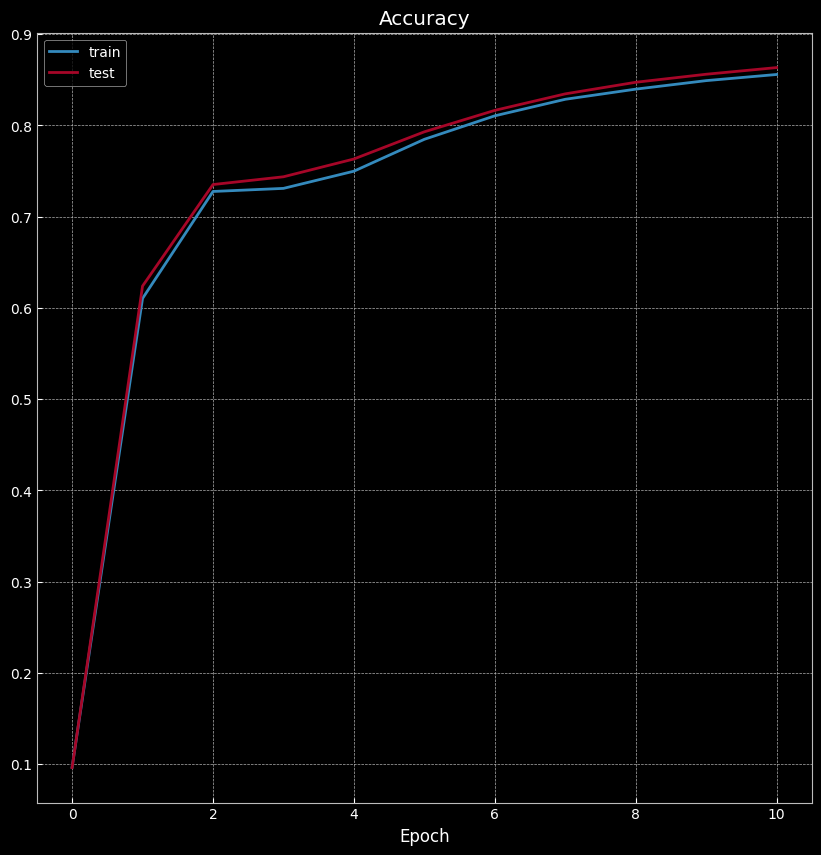

In [15]:
# Plot accuracy
plot_results(results['train_acc'], results['test_acc'], title='Accuracy')

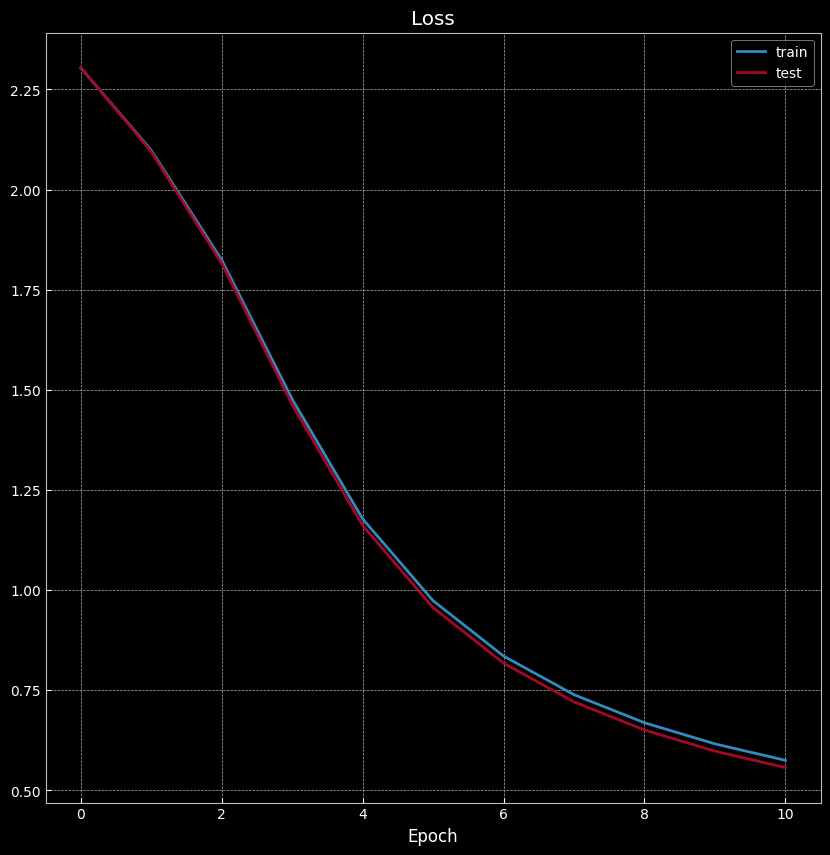

In [16]:
# Plot loss
plot_results(results['train_loss'], results['test_loss'], title='Loss')